In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
columns = ['center','left','right','steering','throttle','reverse', 'speed']
data = pd.read_csv('./driving_log.csv', names = columns, sep=';')

In [3]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

define the dataset

In [5]:
class ImageDataset(Dataset):   
    def __init__(self, csv_file, root_dir, transform=None):
        columns = ['center','left','right','steering','throttle','reverse', 'speed']
        self.annotations = pd.read_csv('./driving_log.csv', sep=';', names = columns)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.root_dir + self.annotations.iloc[idx, 0]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
            
        return image

images are 320 x 160

Let's define the model

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(8*32*32, 100)
        )
        self.bridge = nn.Sequential(nn.Linear(100, 8*32*32))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.bridge(x)
        x = x.reshape(x.shape[0], -1, 32, 32)
        x = self.decoder(x)
        return x


In [9]:
model = Autoencoder()

Now let's define the image preprocessing

In [11]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

In [12]:
street_dataset = ImageDataset('./driving_log.csv', '.', transform=img_transform)

In [13]:
for i, img in enumerate(street_dataset):
    print(i, img.size())

    if i == 3:
        break

0 torch.Size([3, 128, 128])
1 torch.Size([3, 128, 128])
2 torch.Size([3, 128, 128])
3 torch.Size([3, 128, 128])


In [14]:
train_loader = DataLoader(dataset=street_dataset, batch_size=128)

Prepare for training

In [16]:
print(device)
model.to(device)

cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=8192, out_features=100, bias=True)
  )
  (bridge): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
num_epochs = 50
for epoch in range(num_epochs):
    for img in train_loader:
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/50], Loss: 0.0270
Epoch [6/50], Loss: 0.0222
Epoch [11/50], Loss: 0.0184
Epoch [16/50], Loss: 0.0153
Epoch [21/50], Loss: 0.0134
Epoch [26/50], Loss: 0.0121
Epoch [31/50], Loss: 0.0109
Epoch [36/50], Loss: 0.0102
Epoch [41/50], Loss: 0.0097
Epoch [46/50], Loss: 0.0091


In [19]:
torch.save(model.state_dict(), 'Autoencoder.pth')

In [20]:
data.iloc[-2]['center']

'/IMG/center_2020_07_14_14_33_42_917.jpg'

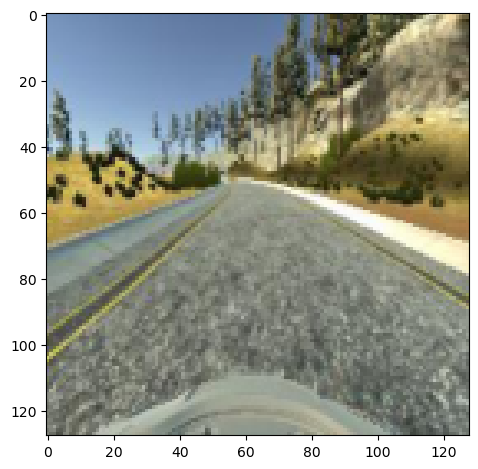

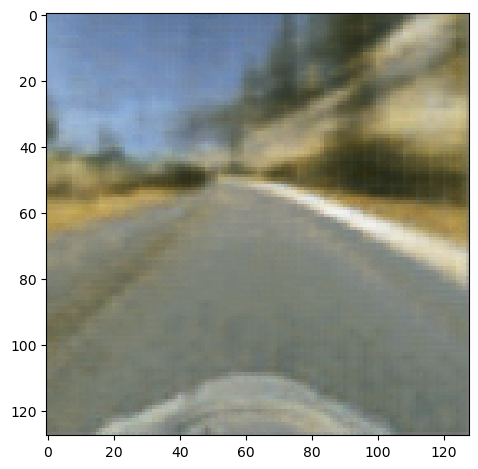

torch.Size([1, 100])


In [21]:
with torch.no_grad():
    for i in range(1):
        image = io.imread( "./" + data.iloc[-(i+1)]['center'])
        image = img_transform(image)
        io.imshow(image.cpu().numpy().transpose((1,2,0)))
        plt.show()
        image = image.to(device)
        image = image.unsqueeze(0)
        reconstruct = model(image)
        reconstruct = reconstruct.squeeze()
        io.imshow(reconstruct.cpu().numpy().transpose((1,2,0)))
        plt.show()
        latent = model.encoder(image)
        print(latent.size())